# DAN for Question Answering

Notebook to take a basic DAN for question answering and attempt to training on larger and larger datasets.  We start with 10 questions/answers which gets 85% accuracy.  We can then attempt to modify the number of hidden nodes, etc. in order to maintain accuracy as we enlarge the training dataset.

In [65]:
%matplotlib notebook 

import time
import json
import random
from pprint import pprint
from nltk.probability import FreqDist
from pprint import pprint
from nltk import word_tokenize

import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torch.utils.data import Dataset
from torch.nn.utils import clip_grad_norm_

from gensim.models import word2vec
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "../data/GoogleNews-vectors-negative300.bin"
word_vectors = KeyedVectors.load_word2vec_format(path, binary=True)
word2ind = {k: v.index for k,v in word_vectors.vocab.items()}
ind2word = {v:k for k,v in word2ind.items()}

In [3]:
train_file = "../data/qanta.train.2018.04.18.json"
dev_file = "../data/qanta.dev.2018.04.18.json"
test_file = "../data/qanta.test.2018.04.18.json"

In [55]:
def load_data(filename):
    data = list()
    with open(filename) as json_data:
        questions = json.load(json_data)["questions"]
        
#         for q in questions:
#             q_text = q['text'].split()
#             label = category_lookup[q['category']]
#             data.append((q_text, label))
    return questions


train_data = load_data(train_file)
dev_data = load_data(dev_file) 
test_data = load_data(test_file)
all_data = train_data + dev_data + test_data

# all_data = all_data[:100]


create lookups for answers

In [53]:
save_model = "topic-dan.pt"
grad_clipping = 5
checkpoint = 5

class DanModel(nn.Module):

    def __init__(self, n_classes, n_hidden_units):
        super(DanModel, self).__init__()
        self.n_classes = n_classes
        self.n_hidden_units = n_hidden_units
        
        self.vocab_size, self.emb_dim = word_vectors.vectors.shape
        self.embeddings = nn.Embedding(self.vocab_size, self.emb_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(word_vectors.vectors))
        self.embeddings.weight.requires_grad = False

#         self.linear1 = nn.Linear(self.emb_dim, n_hidden_units)
#         self.linear2 = nn.Linear(n_hidden_units, 50)
#         self.linear3 = nn.Linear(50, n_classes)
#         self.classifier = nn.Sequential(
#             self.linear1,
#             nn.ReLU(),
#             self.linear2,
#             nn.ReLU(),
#             self.linear3)


        self.linear1 = nn.Linear(self.emb_dim, n_hidden_units)
        self.linear2 = nn.Linear(n_hidden_units, n_classes)
        self.classifier = nn.Sequential(
            self.linear1,
            nn.ReLU(),
            self.linear2)
        self.softmax = nn.Softmax()

    def forward(self, input_text, text_len):
        """
        Model forward pass

        Keyword arguments:
        input_text : vectorized question text
        text_len : batch * 1, text length for each question
        is_prob: if True, output the softmax of last layer

        """
        # get word embeddings
        text_embed = self.embeddings(input_text)

        # calculate the mean embeddings
        encoded = text_embed.sum(1)
        encoded /= text_len.view(text_embed.size(0), -1)

        # run data through the classifier
        logits = self.classifier(encoded)

        return self.softmax(logits)


In [54]:
class Question_Dataset(Dataset):

    def __init__(self, examples, lookup):
        self.examples = examples
        self.lookup = lookup

    def __getitem__(self, index):
        return vectorize(self.examples[index], self.lookup)

    def __len__(self):
        return len(self.examples)


def vectorize(ex, lookup):
    """
    vectorize a single example based on the word2ind dict.

    Keyword arguments:
    exs: list of input questions-type pairs
    ex: tokenized question sentence (list)
    label: type of question sentence

    Output:  vectorized sentence(python list) and label(int)
    e.g. ['text', 'test', 'is', 'fun'] -> [0, 2, 3, 4]
    """
    vec_text = []
    question_text, question_label = ex
    
    for idx, token in enumerate(question_text):
        if token in lookup:
            vec_text.append(lookup[token])

    return vec_text, question_label


def batchify(batch):
    """
    Gather a batch of individual examples into one batch,
    which includes the question text, question length and labels

    Keyword arguments:
    batch: list of outputs from vectorize function
    """

    question_len = list()
    label_list = list()
    for ex in batch:
        question_len.append(len(ex[0]))
        label_list.append(ex[1])
    target_labels = torch.LongTensor(label_list)
    x1 = torch.LongTensor(len(question_len), max(question_len)).zero_()
    for i in range(len(question_len)):
        question_text = batch[i][0]
        vec = torch.LongTensor(question_text)
        x1[i, :len(question_text)].copy_(vec)
    q_batch = {'text': x1, 'len': torch.FloatTensor(question_len), 'labels': target_labels}
    return q_batch        

In [44]:
def train(model, train_data_loader, dev_data_loader, accuracy, device):
    """
    Train the current model

    Keyword arguments:
    model: model to be trained
    train_data_loader: pytorch build-in data loader output for training examples
    dev_data_loader: pytorch build-in data loader output for dev examples
    accuracy: previous best accuracy
    device: cpu of gpu
    """

    model.train()
    optimizer = torch.optim.Adamax(model.parameters())
    criterion = nn.CrossEntropyLoss()
    print_loss_total = 0
    epoch_loss_total = 0
    start = time.time()

    for idx, batch in enumerate(train_data_loader):
        question_text = batch['text'].to(device)
        question_len = batch['len']
        labels = batch['labels']

        output = model(question_text, question_len)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

#         clip_grad_norm_(model.parameters(), grad_clipping)
        print_loss_total += loss.data.numpy()
        epoch_loss_total += loss.data.numpy()

        if idx % checkpoint == 0 and idx > 0:
            print_loss_avg = print_loss_total / checkpoint

            print('number of steps: %d, loss: %.5f time: %.5f' % (idx, print_loss_avg, time.time()- start))
            print_loss_total = 0
            curr_accuracy = evaluate(dev_data_loader, model, device)
            if accuracy < curr_accuracy:
                torch.save(model, save_model)
                accuracy = curr_accuracy
    return curr_accuracy


def evaluate(data_loader, model, device):
    """
    evaluate the current model, get the accuracy for dev/test set

    Keyword arguments:
    data_loader: pytorch build-in data loader output
    model: model to be evaluated
    device: cpu of gpu
    """
    model.eval()
    num_examples = 0
    error = 0
    for idx, batch in enumerate(data_loader):
        question_text = batch['text'].to(device)
        question_len = batch['len']
        labels = batch['labels']

        logits = model(question_text, question_len)

        top_n, top_i = logits.topk(1)
        num_examples += question_text.size(0)
        error += torch.nonzero(top_i.squeeze() - torch.LongTensor(labels)).size(0)

    accuracy = 1 - error / num_examples
    print('accuracy', accuracy)
    return accuracy

In [61]:
device = "cpu"

DanModel(
  (embeddings): Embedding(3000000, 300, padding_idx=0)
  (linear1): Linear(in_features=300, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=50, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=50, bias=True)
  )
  (softmax): Softmax()
)


DanModel(
  (embeddings): Embedding(3000000, 300, padding_idx=0)
  (linear1): Linear(in_features=300, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=50, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=50, bias=True)
  )
  (softmax): Softmax()
)
start epoch 0
number of steps: 2, loss: 5.86814 time: 0.37226
accuracy 0.06000000000000005
number of steps: 4, loss: 3.91270 time: 8.35673
accuracy 0.06000000000000005
start epoch 1
number of steps: 2, loss: 5.86725 time: 0.01287
accuracy 0.09999999999999998
number of steps: 4, loss: 3.91245 time: 3.47338
accuracy 0.16000000000000003
start epoch 2
number of steps: 2, loss: 5.86682 time: 0.01874
accuracy 0.16000000000000003
number of steps: 4, loss: 3.91166 time: 0.04369
accuracy 0.18000000000000005
start epoch 3
number of steps: 2, loss: 5.86575 time: 0.01101
accuracy 0.19999999999999996
number of ste

accuracy 0.62
number of steps: 4, loss: 3.39307 time: 0.02062
accuracy 0.62
start epoch 59
number of steps: 2, loss: 5.01758 time: 0.00773
accuracy 0.62
number of steps: 4, loss: 3.29587 time: 0.01907
accuracy 0.62
start epoch 60
number of steps: 2, loss: 4.96871 time: 0.00771
accuracy 0.62
number of steps: 4, loss: 3.34384 time: 0.01898
accuracy 0.62
start epoch 61
number of steps: 2, loss: 5.01730 time: 0.00785
accuracy 0.62
number of steps: 4, loss: 3.29400 time: 0.02001
accuracy 0.62
start epoch 62
number of steps: 2, loss: 5.01645 time: 0.00730
accuracy 0.62
number of steps: 4, loss: 3.29374 time: 0.01992
accuracy 0.62
start epoch 63
number of steps: 2, loss: 4.81714 time: 0.00823
accuracy 0.62
number of steps: 4, loss: 3.49228 time: 0.02074
accuracy 0.62
start epoch 64
number of steps: 2, loss: 4.86674 time: 0.00905
accuracy 0.62
number of steps: 4, loss: 3.44221 time: 0.02343
accuracy 0.62
start epoch 65
number of steps: 2, loss: 5.11373 time: 0.00849
accuracy 0.62
number of ste

accuracy 0.62
number of steps: 4, loss: 3.49280 time: 0.02061
accuracy 0.62
start epoch 119
number of steps: 2, loss: 4.96599 time: 0.00740
accuracy 0.62
number of steps: 4, loss: 3.34405 time: 0.01748
accuracy 0.62
start epoch 120
number of steps: 2, loss: 4.96637 time: 0.00752
accuracy 0.62
number of steps: 4, loss: 3.34376 time: 0.02012
accuracy 0.62
start epoch 121
number of steps: 2, loss: 5.26502 time: 0.00894
accuracy 0.62
number of steps: 4, loss: 3.04518 time: 0.02111
accuracy 0.62
start epoch 122
number of steps: 2, loss: 5.01560 time: 0.00876
accuracy 0.62
number of steps: 4, loss: 3.29442 time: 0.02117
accuracy 0.62
start epoch 123
number of steps: 2, loss: 4.96604 time: 0.00898
accuracy 0.62
number of steps: 4, loss: 3.34381 time: 0.02141
accuracy 0.62
start epoch 124
number of steps: 2, loss: 5.01575 time: 0.00915
accuracy 0.62
number of steps: 4, loss: 3.29377 time: 0.02166
accuracy 0.62
start epoch 125
number of steps: 2, loss: 4.86626 time: 0.00877
accuracy 0.62
number

number of steps: 2, loss: 4.91608 time: 0.01671
accuracy 0.62
number of steps: 4, loss: 3.39440 time: 0.03674
accuracy 0.62
start epoch 182
number of steps: 2, loss: 5.01656 time: 0.01753
accuracy 0.62
number of steps: 4, loss: 3.29404 time: 0.03457
accuracy 0.62
start epoch 183
number of steps: 2, loss: 4.96570 time: 0.01101
accuracy 0.62
number of steps: 4, loss: 3.34517 time: 0.02669
accuracy 0.62
start epoch 184
number of steps: 2, loss: 5.06595 time: 0.01097
accuracy 0.62
number of steps: 4, loss: 3.24500 time: 0.02571
accuracy 0.62
start epoch 185
number of steps: 2, loss: 5.06617 time: 0.00876
accuracy 0.62
number of steps: 4, loss: 3.24464 time: 0.02204
accuracy 0.62
start epoch 186
number of steps: 2, loss: 4.96644 time: 0.00936
accuracy 0.62
number of steps: 4, loss: 3.34462 time: 0.02199
accuracy 0.62
start epoch 187
number of steps: 2, loss: 4.81682 time: 0.00922
accuracy 0.62
number of steps: 4, loss: 3.49454 time: 0.02120
accuracy 0.62
start epoch 188
number of steps: 2, 

<IPython.core.display.Javascript object>


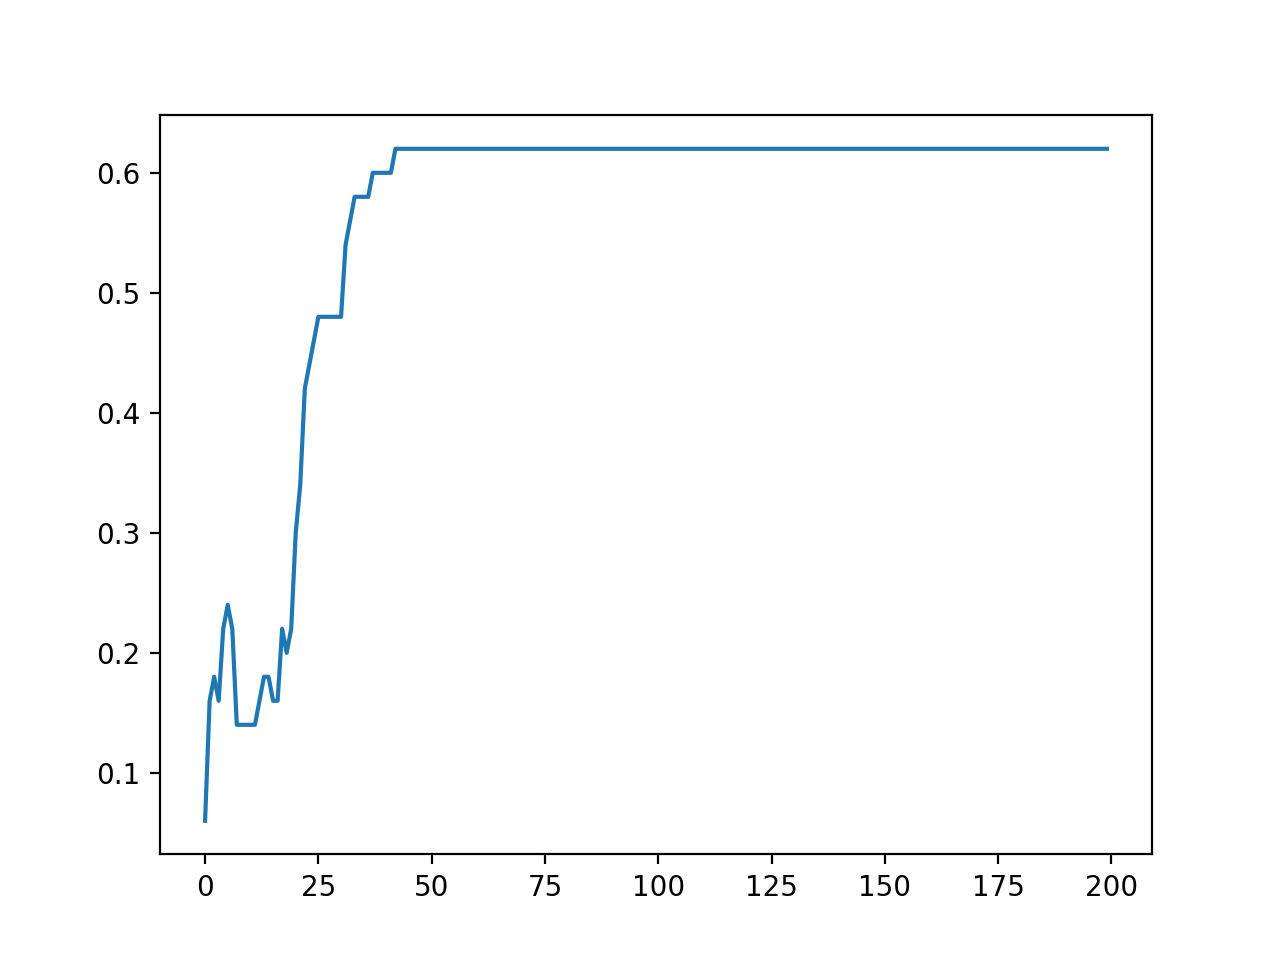

In [64]:
# Start Training
checkpoint = 2
batch_size = 10
num_epochs = 200

accuracy = 0
accuracies = []

data = all_data[:50]
ans2idx = {q["page"]: idx for idx, q in enumerate(data) if q["page"]}
data = [(word_tokenize(q["text"]), ans2idx[q["page"]]) for q in data]

n_classes = len(ans2idx.keys())

model = DanModel(n_classes, n_hidden_units=200)
model.to(device)
print(model)


# Create testing dataloader
train_dataset = Question_Dataset(data, word2ind)
train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=0, collate_fn=batchify)

dev_dataset = Question_Dataset(data, word2ind)
dev_sampler = torch.utils.data.sampler.SequentialSampler(dev_dataset)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size,
    sampler=dev_sampler, num_workers=0, collate_fn=batchify)


# Train / Fit
for epoch in range(num_epochs):
    print('start epoch %d' % epoch)
    accuracy = train(model, train_loader, dev_loader, accuracy, device)
    accuracies.append(accuracy)

    
# Test
print('\nstart testing:\n')
evaluate(train_loader, model, device)
    
_ = pd.Series(accuracies).plot()